In [10]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')
from exp.nb_06 import *

import luke_model
import luke_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
x_train,y_train,x_valid,y_valid = luke_data.get_data()
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [12]:
c = 1
bs = 20
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [13]:
model = luke_model.Luke(cn_dropout=0.05)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
learn = Learner(model, optimizer, loss_func, data)
run = Runner(cbs=[AvgStatsCallback([accuracy])],cb_funcs=[CudaCallback])

In [15]:
# run.fit(30, learn)

In [16]:
from livelossplot import PlotLosses
class LivelossCallback(AvgStatsCallback):
    def __init__(self, metrics):
        super().__init__(metrics)
        self.liveloss = PlotLosses(skip_first=0)
        self.metricnames = [m.__name__ for m in metrics]
        self.logs={}
    
    def begin_epoch(self):
        super().begin_epoch()
        self.logs={}
        self.iteration = 0
        
    def after_loss(self):
        super().after_loss()
        if self.in_train:
            self.iteration += 1
            print('\r[%d, %5d] Train_loss: %.3f' %(self.epoch + 1, self.iteration, self.loss),end='')
    
    def after_epoch(self):
        super().after_epoch()
        self.logs['loss'] = self.train_stats.avg_stats[0]
        self.logs['val_loss'] = self.valid_stats.avg_stats[0]
        for i,metric in enumerate(self.metricnames):
            self.logs[metric] = self.train_stats.avg_stats[i+1].item()
            self.logs['val_'+metric] = self.valid_stats.avg_stats[i+1].item()
        self.liveloss.update(self.logs)
        self.liveloss.draw()

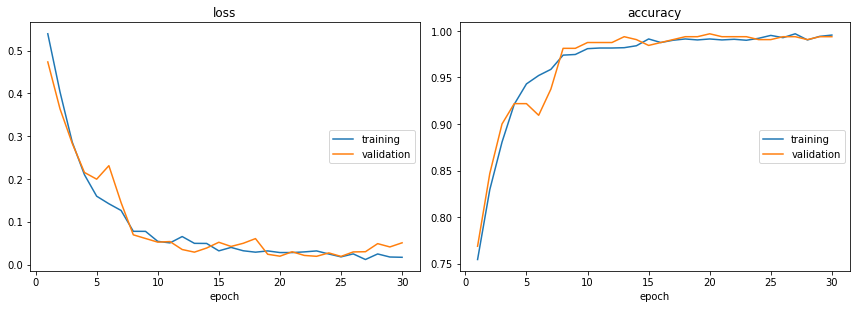

loss:
training   (min:    0.012, max:    0.539, cur:    0.017)
validation (min:    0.019, max:    0.474, cur:    0.051)

accuracy:
training   (min:    0.755, max:    0.997, cur:    0.995)
validation (min:    0.769, max:    0.997, cur:    0.994)


In [17]:
run = Runner([LivelossCallback([accuracy])],cb_funcs=[CudaCallback])
run.fit(30, learn)

In [15]:
torch.save(model.state_dict(), '../../local/luke_model.pth')

In [16]:
Runner??

Init signature: Runner(cbs=None, cb_funcs=None)
Docstring:      <no docstring>
Source:        
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        self.in_train = False
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.los

In [17]:
Callback??

Init signature: Callback()
Docstring:      <no docstring>
Source:        
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)

    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False
File:           ~/Projects/lookilooki/model_lookilooki/src/exp/nb_05b.py
Type:           type
Subclasses:     TrainEvalCallback, AvgStatsCallback, Recorder, ParamScheduler, LR_Find, CudaCallback, BatchTransformXCallback
